## Bienvenidos al Notebook del trade de la base

En este notebook vamos a calcular la base para distintos contratos futuros de criptomonedas, concretamente Bitcoin y Ethereum en Binance. Vamos a usar la librería [ccxt](https://github.com/ccxt/ccxt) para descargar los datos. No obstante, podéis usar multitud de librerías, incluso fabricar vuestros propios códigos para comunicaros con los mercados y pedir los datos mediante API o sockets.

<span style="color:blue">Importante: instalar las librerías para que el código funcione.</span>. Simplemente ejecutad el siguiente comando desde una terminal en la misma ruta del código: python -m pip install -r requirements.txt.

In [1]:
# Importamos las liberías para trabajar con datos y gráficos
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates
from datetime import datetime
import pandas as pd
import numpy as np
import ccxt # Librería para descargar los datos de criptomonedas

# https://stackoverflow.com/questions/47404653/pandas-0-21-0-timestamp-compatibility-issue-with-matplotlib 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
binance = ccxt.binance() # Creamos el objeto para comunicarnos con Binance

Vamos a descargar los precios para Bitcoin (BTC) del futuro más cercano en el tiempo y también del spot. Los precios de los futuros históricos no están disponibles desde ccxt. 

Mediante el método "fetch_ohlcv" descargamos las barras de mercado cada 8h. Las barras de marcado resumen los datos para un rango temporal, en este caso de 8 horas (8h). El resumen consiste en:
- El precio de apertura del intervalo (la o de ohlcv viene de open).
- El precio más alto del intervalo (la h de ohlcv viene de high).
- El precio más bajo del intervalo (la l de ohlcv viene de low).
- El precio de cierre del intervalo (la c de ohlcv viene close).
- el volumen total del intervalo (la v de ohlcv viene de volumen).

In [3]:
nombre_futuro = 'BTCUSDT_230929'
nombre_spot = 'BTCUSDT'
btc_fut = binance.fetch_ohlcv(nombre_futuro, '8h')
btc_spot = binance.fetch_ohlcv(nombre_spot, '8h')

Creamos un dataframe de pandas con los datos que devuelve ccxt, una para el spot y otro para el futuro.

In [4]:
btc_fut_df = pd.DataFrame(btc_fut, columns = ['ts', 'o', 'h', 'l', 'c', 'v'])
btc_spot_df = pd.DataFrame(btc_spot, columns = ['ts', 'o', 'h', 'l', 'c', 'v'])

Transformamos el índice de los dataframe con la fecha en formato datetime para poder trabajar con ella.

In [5]:
btc_fut_df['ts'] = btc_fut_df['ts'].apply(lambda x: datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
btc_spot_df['ts'] = btc_spot_df['ts'].apply(lambda x: datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))

btc_fut_df.set_index('ts', inplace=True)
btc_spot_df.set_index('ts', inplace=True)

Las cinco primeras filas de los precios del futuro. Como podéis observar las filas van de 8 horas en 8 horas.

In [6]:
btc_fut_df.head(5)

,o,h,l,c,v
ts,,,,,
2023-06-25 00:00:00,30711.4,31939.0,30711.4,31081.1,84.014
2023-06-25 08:00:00,31081.7,31264.8,30965.1,31124.6,112.503
2023-06-25 16:00:00,31134.4,31236.0,30651.0,30880.3,131.964
2023-06-26 00:00:00,30881.2,31000.0,30436.6,30830.8,181.676
2023-06-26 08:00:00,30832.0,31080.0,30534.5,30841.3,133.316


Las cinco primeras filas de los precios spot.

In [7]:
btc_spot_df.head(5)

,o,h,l,c,v
ts,,,,,
2023-04-15 08:00:00,30433.29,30470.00,30285.0,30325.27,7940.29532
2023-04-15 16:00:00,30325.27,30360.19,30202.0,30295.09,7588.17359
2023-04-16 00:00:00,30295.10,30399.40,30120.0,30344.97,6305.55476
2023-04-16 08:00:00,30344.97,30362.00,30160.4,30332.98,8318.72236
2023-04-16 16:00:00,30332.98,30549.99,30192.0,30304.65,11807.71610


A continuación juntamos ambas tablas haciendo coincidir las fechas y nos quedamos con el precio de apertura.

In [8]:
df = pd.concat([btc_spot_df.o, btc_fut_df.o], axis=1, sort=True)
df.columns = ['precio_spot', 'precio_futuro']
df = df.dropna()
df.head()

,precio_spot,precio_futuro
ts,,
2023-06-25 00:00:00,30527.44,30711.4
2023-06-25 08:00:00,30723.78,31081.7
2023-06-25 16:00:00,30585.16,31134.4
2023-06-26 00:00:00,30462.67,30881.2
2023-06-26 08:00:00,30404.28,30832.0


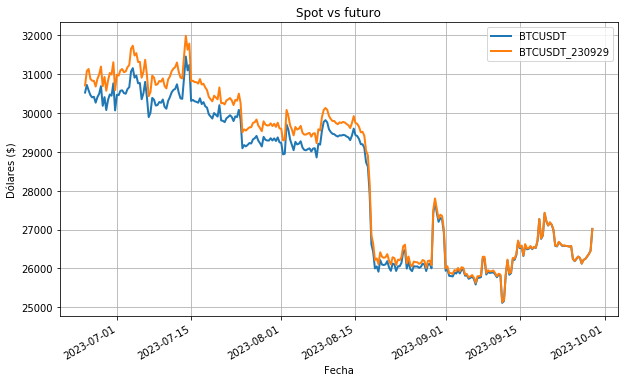

In [9]:
plt.figure(figsize=(10, 6))
fechas = [datetime.strptime(ax, '%Y-%m-%d %H:%M:%S') for ax in df.index]
plt.plot(fechas, df.precio_spot.values, label=nombre_spot, linewidth=2)
plt.plot(fechas, df.precio_futuro.values, label=nombre_futuro, linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Dólares ($)')
plt.title('Spot vs futuro')
plt.grid(True)
plt.legend()
plt.gcf().autofmt_xdate()
plt.savefig('btc_spot_fut.png', format='png', dpi = 500)
plt.show()

Vamos a calcular la base como <font size=5> $\frac{precio_f - precio_s}{precio_s}$ $\times$ 100 </font>, donde:
- $precio_f$ es el precio del futuro
- $precio_s$ es el precio del spot

In [10]:
base_df = (df.precio_futuro - df.precio_spot) / df.precio_spot * 100
base_df.head() 

ts
2023-06-25 00:00:00    0.602605
2023-06-25 08:00:00    1.164961
2023-06-25 16:00:00    1.795773
2023-06-26 00:00:00    1.373911
2023-06-26 08:00:00    1.406776
dtype: float64

Es importante anualizar las bases anteriores. Si lo pensáis, cada uno de los porcentajes anteriores corresponde a un número de días distinto. Los primeros porcentajes van desde junio hasta finales de septiembre. Es decir, no es lo mismo un 1% mensual que un 1% trimestral. Es por ello que anualizamos los porcentajes de la siguiente manera:

1. Calculamos el porcentaje diario como: base_df / número de días
2. Multiplicamos por 365

El número de días sería entre la fecha de vencimiento del futuro (29/09/2023) y la fecha en la que se calcula la base. Por tanto, la fórmula para anualizar la base sería:

<font size=3> base anualizada = $\frac{base}{365}$ $\times$ numero de dias </font>

In [11]:
fechas = [datetime.strptime(ax, '%Y-%m-%d %H:%M:%S') for ax in base_df.index]
fecha_futuro = datetime(2023, 9, 29, 0, 0)
dias_para_vencimiento = np.array([(fecha_futuro - ax).days for ax in fechas])

In [12]:
base_anualizada_df = base_df / dias_para_vencimiento * 365
base_anualizada_df.head()

ts
2023-06-25 00:00:00    2.291156
2023-06-25 08:00:00    4.475902
2023-06-25 16:00:00    6.899548
2023-06-26 00:00:00    5.278711
2023-06-26 08:00:00    5.462480
dtype: float64

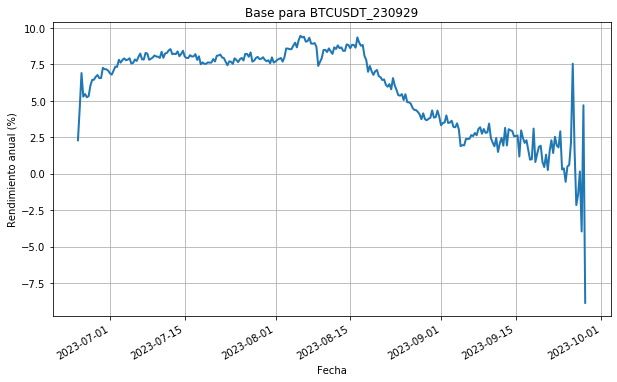

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(fechas, base_anualizada_df.values, linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Rendimiento anual (%)')
plt.title('Base para ' + nombre_futuro)
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.savefig('base_btc.png', format='png', dpi = 500)
plt.show()

In [14]:
import dill
filename = 'globalsave.pkl'
dill.dump_session(filename)

In [1]:
import dill
filename = 'globalsave.pkl'
dill.load_session(filename)

In [2]:
base_anualizada_df

ts
2023-06-25 00:00:00    2.291156
2023-06-25 08:00:00    4.475902
2023-06-25 16:00:00    6.899548
2023-06-26 00:00:00    5.278711
2023-06-26 08:00:00    5.462480
                         ...   
2023-09-27 08:00:00   -3.963408
2023-09-27 16:00:00    4.690086
2023-09-28 00:00:00   -8.857544
2023-09-28 08:00:00        -inf
2023-09-28 16:00:00        -inf
Length: 288, dtype: float64